# Exercise 6: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw6_123456789_987654321.ipynb` if you submitted in pairs and `hw6_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## Color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

Also, note that `numpy.power()` is a slow function! https://stackoverflow.com/questions/25254541/why-is-numpy-power-60x-slower-than-in-lining

In [ ]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

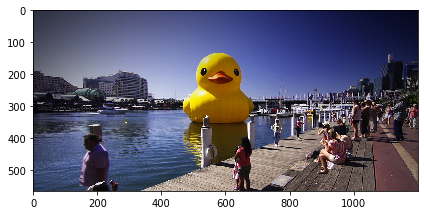

(564, 1200, 3)


In [ ]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [ ]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows * cols, 3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [ ]:
def get_random_centroids(X, k):
    """
    Create random cluster centroids.
    Inputs:
    - X: a single image of shape (num_features, 3)
    - k: the number of desired centroids
    Output:
    - List of k randomly chosen centroids of shape (k, 3)
    """
    centroids = []
    m = np.shape(X)[0]

    for _ in range(k):
        rand_idx = np.random.randint(0, m)  # upto and excluding m
        centroids.append(X[rand_idx])

    return np.array(centroids)

In [ ]:
k = 7 
centroids = get_random_centroids(image, k)

## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [ ]:
def lp_distance(X, centroids, p=2):
    # get X and centroid to same dimensions
    X = np.repeat(np.expand_dims(X, 0), len(centroids), axis=0).astype(float)
    centroids = np.expand_dims(centroids, 1)
    diffs = np.abs(X - centroids)
    distances = np.sum(diffs ** p, axis=2) ** (1 / p)

    return distances

In [ ]:
# p=1: Manhattan, p=2: Euclidean ...
distances = lp_distance(image, centroids, 5)  # each row represents the distances from the corresponding centroid (row number) to EVERY point in the image

In [ ]:
assert distances.shape == (centroids.shape[0], image.shape[0])
distances.shape

(7, 676800)

## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [ ]:
def kmeans(X, k, p, max_iter=100, cluster_calculation_criteria='mean'):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    - cluster_calculation_criteria: 0=mean, 1=median
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = np.zeros_like(X.shape[0])  # for each pixel, we find its closest centroid - so we have |pixels| values
    centroids = get_random_centroids(X, k)

    for iteration in range(max_iter):
        new_centroids = np.zeros_like(centroids)
        distances = lp_distance(X, centroids, p)
        # for each column c in distances, return i - the index of the min value in c
        # i is the number of the closest centroid for a pixel c in X
        classes = np.argmin(distances, axis=0)

        for i in range(k):
            centroid_points = X[classes == i, :]  # filter pixels for which their closest centroid is the i'th centroid

            # calculate mean/median along every column (R/G/B)
            if cluster_calculation_criteria == 'mean':
                centroid = np.mean(centroid_points, axis=0)
            elif cluster_calculation_criteria == 'median':
                centroid = np.median(centroid_points, axis=0)
            else:
                raise Exception('Unknown cluster calculation criteria')

            new_centroids[i, :] = centroid

        if np.array_equal(centroids, new_centroids):
            # if true, then no centroid was updated --> no improvement
            break
        else:
            centroids = new_centroids

    return centroids, classes

In [ ]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
centroids, classes = kmeans(image, k=4, p=1, max_iter=100)
# centroids, classes = kmeans(image, k=16, p=1, max_iter=100)
# centroids, classes = kmeans(image, k=16, p=1, max_iter=100, cluster_calculation_criteria='median')
end = timer()
print(f'time = {timedelta(seconds=end-start)}')

time = 0:00:01.663727


We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

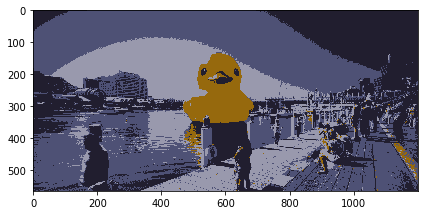

In [ ]:
classes = classes.reshape(rows, cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1], 3), dtype=np.uint8)

for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
        compressed_image[i, j, :] = centroids[classes[i, j], :]

io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Run the algorithm for each of the following values for `p = [1,2,3,4,5]` . Test multiple values for `k=[4,8,16]` using two different cluster calculation criteria: the mean and the median of the cluster. For each test, calculate the intertia and visualize it using graphs. Explain your results.

In [ ]:
def calculate_inertia(X, centroids, p):
    # "inertia is the sum of the squared distances between each training instance and its closest centroid"
    return np.sum(np.square(lp_distance(X, centroids, p).min(axis=0)))

p = 1, k = 4, criteria = mean, inertia = 3333914257.0
p = 1, k = 8, criteria = mean, inertia = 1645134298.0
p = 1, k = 16, criteria = mean, inertia = 759906171.0
p = 1, k = 4, criteria = median, inertia = 3443727881.0
p = 1, k = 8, criteria = median, inertia = 1704139520.0
p = 1, k = 16, criteria = median, inertia = 833943931.0


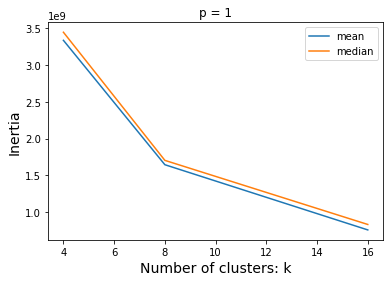

p = 2, k = 4, criteria = mean, inertia = 1338323056.0
p = 2, k = 8, criteria = mean, inertia = 685639563.0
p = 2, k = 16, criteria = mean, inertia = 315590362.0
p = 2, k = 8, criteria = median, inertia = 767297611.0
p = 2, k = 16, criteria = median, inertia = 371944806.0


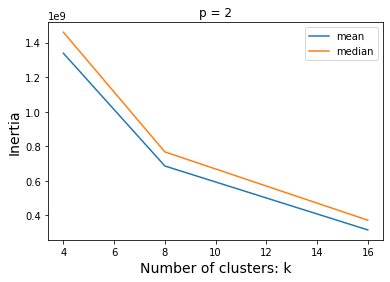

p = 3, k = 4, criteria = mean, inertia = 1050767408.9296638
p = 3, k = 8, criteria = mean, inertia = 533073195.2407058
p = 3, k = 16, criteria = mean, inertia = 243122627.7795839
p = 3, k = 4, criteria = median, inertia = 1153634545.1360674
p = 3, k = 8, criteria = median, inertia = 608161116.8728346
p = 3, k = 16, criteria = median, inertia = 243767887.8052789


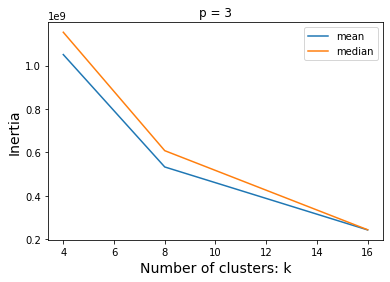

p = 4, k = 4, criteria = mean, inertia = 949194281.6329429
p = 4, k = 8, criteria = mean, inertia = 496968032.8619077
p = 4, k = 16, criteria = mean, inertia = 255951423.5517549
p = 4, k = 4, criteria = median, inertia = 1041687149.5942379
p = 4, k = 8, criteria = median, inertia = 513246367.5046128
p = 4, k = 16, criteria = median, inertia = 264036947.40092656


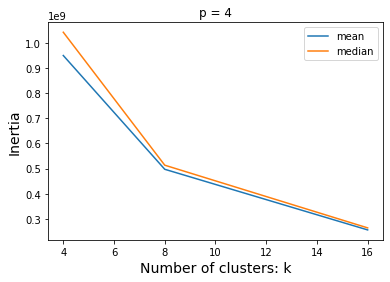

p = 5, k = 4, criteria = mean, inertia = 899750807.9794316
p = 5, k = 8, criteria = mean, inertia = 443989004.4657656
p = 5, k = 16, criteria = mean, inertia = 222746909.01485017
p = 5, k = 4, criteria = median, inertia = 928921034.1603187
p = 5, k = 8, criteria = median, inertia = 457286963.94196904
p = 5, k = 16, criteria = median, inertia = 251278572.17070326


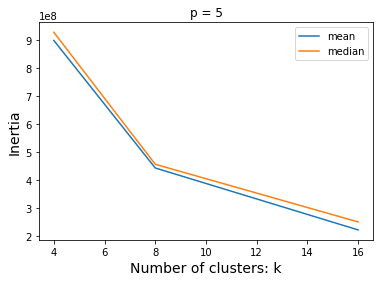

In [ ]:
p_values = [1, 2, 3, 4, 5]
k_values = [4, 8, 16]
cluster_calculation_criterias = ['mean', 'median']

for p in p_values:
    for criteria in cluster_calculation_criterias:
        inertias = []

        for k in k_values:
            centroids, classes = kmeans(image, k=k, p=p, cluster_calculation_criteria=criteria)
            inertia = calculate_inertia(image, centroids, p)
            inertias.append(inertia)
            print(f'p = {p}, k = {k}, criteria = {criteria}, inertia = {inertia}')
        
        plt.title(f'p = {p}')
        plt.plot(k_values, inertias, label=criteria)
    
    plt.xlabel(f'Number of clusters: k', fontsize=14)
    plt.ylabel(f'Inertia', fontsize=14)
    plt.legend()
    plt.show()

In all plots we see the "elbow" when k=8.<br>
Meaning, this is the optimal number of clusters in the image (at least in terms of inertia).<br>

The minimal inertia value for k=8 is when p=5 for both 'mean' and median' clustering methods, so this will be our go-to parameters for this model.